In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt

from tqdm import tqdm
import copy

pd.set_option('display.max_columns', 500)

In [3]:
BALL_VARS = ['ballx', 'bally']
VARS_X = [f'p{i}x' for i in range(1, 23)]
VARS_Y = [f'p{i}y' for i in range(1, 23)]
CONTEXT_VARS = BALL_VARS + VARS_X + VARS_Y
FRAME_VARS = [f.replace('x', 'dx').replace('y', 'dy') for f in CONTEXT_VARS]

In [4]:
N_CONTEXT_FRAMES = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
MODEL_LAYERS = {
    'layer_1': {
        'input': ['playDirection', 'frame_no'] + [f'c1_{var}' for var in CONTEXT_VARS] + [f'c1_{var}' for var in FRAME_VARS],
        'output': VARS_X,
    },
    'layer_2': {
        'input': ['playDirection', 'frame_no'] + [f'c1_{var}' for var in CONTEXT_VARS] + [f'c1_{var}' for var in FRAME_VARS] + [var for var in FRAME_VARS if ('dx' in var) and ('ball' not in var)],
        'output': VARS_Y,
    },
    'layer_3': {
        'input': ['playDirection', 'frame_no'] + [f'c1_{var}' for var in CONTEXT_VARS] + [f'c1_{var}' for var in FRAME_VARS] + [var for var in FRAME_VARS if ('dx' in var) and ('ball' not in var)] + [var for var in FRAME_VARS if ('dy' in var) and ('ball' not in var)],
        'output': BALL_VARS,
    },
}

bf = 2
print('playDirection', 0)
print('frame_no', 1)
print('c1_ball_xy', bf, bf + len(BALL_VARS))
print('c1_player_x', bf + len(BALL_VARS), bf + len(BALL_VARS) + len(VARS_X))
print('c1_player_y', bf + len(BALL_VARS) + len(VARS_X), bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y))
print('c1_ball_dxdy', bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y), bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS))
print('c1_player_dx', bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS), bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS) + len(VARS_X))
print('c1_player_dy', bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS) + len(VARS_X), bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS) + len(VARS_X) + len(VARS_Y))
print('player_dx', bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS) + len(VARS_X) + len(VARS_Y), bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(VARS_X))
print('player_dy', bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(VARS_X), bf + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(BALL_VARS) + len(VARS_X) + len(VARS_Y) + len(VARS_X) + len(VARS_Y))
print(len(MODEL_LAYERS['layer_3']['input']))

playDirection 0
frame_no 1
c1_ball_xy 2 4
c1_player_x 4 26
c1_player_y 26 48
c1_ball_dxdy 48 50
c1_player_dx 50 72
c1_player_dy 72 94
player_dx 94 116
player_dy 116 138
138


# Loading data

In [6]:
data = pd.read_feather('data/tracking4.feather')

In [7]:
features = ['playDirection', 'frame_no']
# add context vars
i = 1
data_context = data.shift(i)
data_context.loc[data_context['gameId'] != data['gameId'], FRAME_VARS] = pd.NA
data_context = data_context[CONTEXT_VARS].add_prefix(f'c{i}_')
data = pd.concat([data, data_context], axis=1)
features += list(data_context.columns)
# add frame vars
for i in range(1, N_CONTEXT_FRAMES + 1):
    data_context = data.shift(i)
    data_context.loc[data_context['gameId'] != data['gameId'], FRAME_VARS] = pd.NA
    data_context = data_context[FRAME_VARS].add_prefix(f'c{i}_')
    data = pd.concat([data, data_context], axis=1)
    features += list(data_context.columns)

data = data.dropna()

In [8]:
data

,gameId,playId,frameId,is_after_snap,playDirection,ballx,bally,balldx,balldy,p1x,p1y,p1dx,p1dy,p2x,p2y,p2dx,p2dy,p3x,p3y,p3dx,p3dy,p4x,p4y,p4dx,p4dy,p5x,p5y,p5dx,p5dy,p6x,p6y,p6dx,p6dy,p7x,p7y,p7dx,p7dy,p8x,p8y,p8dx,p8dy,p9x,p9y,p9dx,p9dy,p10x,p10y,p10dx,p10dy,p11x,p11y,p11dx,p11dy,p12x,p12y,p12dx,p12dy,p13x,p13y,p13dx,p13dy,p14x,p14y,p14dx,p14dy,p15x,p15y,p15dx,p15dy,p16x,p16y,p16dx,p16dy,p17x,p17y,p17dx,p17dy,p18x,p18y,p18dx,p18dy,p19x,p19y,p19dx,p19dy,p20x,p20y,p20dx,p20dy,p21x,p21y,p21dx,p21dy,p22x,p22y,p22dx,p22dy,snap_frame,frame_no,end_frame,is_end_frame,c1_ballx,c1_bally,c1_p1x,c1_p2x,c1_p3x,c1_p4x,c1_p5x,c1_p6x,c1_p7x,c1_p8x,c1_p9x,c1_p10x,c1_p11x,c1_p12x,c1_p13x,c1_p14x,c1_p15x,c1_p16x,c1_p17x,c1_p18x,c1_p19x,c1_p20x,c1_p21x,c1_p22x,c1_p1y,c1_p2y,c1_p3y,c1_p4y,c1_p5y,c1_p6y,c1_p7y,c1_p8y,c1_p9y,c1_p10y,c1_p11y,c1_p12y,c1_p13y,c1_p14y,c1_p15y,c1_p16y,c1_p17y,c1_p18y,c1_p19y,c1_p20y,c1_p21y,c1_p22y,c1_balldx,c1_balldy,c1_p1dx,c1_p2dx,c1_p3dx,c1_p4dx,c1_p5dx,c1_p6dx,c1_p7dx,c1_p8dx,c1_p9dx,c1_p10dx,c1_p11dx,c1_p12dx,c1_p13dx,c1_p14dx,c1_p15dx,c1_p16dx,c1_p17dx,c1_p18dx,c1_p19dx,c1_p20dx,c1_p21dx,c1_p22dx,c1_p1dy,c1_p2dy,c1_p3dy,c1_p4dy,c1_p5dy,c1_p6dy,c1_p7dy,c1_p8dy,c1_p9dy,c1_p10dy,c1_p11dy,c1_p12dy,c1_p13dy,c1_p14dy,c1_p15dy,c1_p16dy,c1_p17dy,c1_p18dy,c1_p19dy,c1_p20dy,c1_p21dy,c1_p22dy
2,2022090800,56,3,False,0,0.710000,0.556098,-0.000083,0.000000,0.744000,0.553846,-0.000917,0.000188,0.736500,0.565103,-0.001750,-0.000563,0.758667,0.522326,-0.000167,-0.004690,0.745833,0.539587,-0.000917,-0.000938,0.753333,0.543902,-0.000417,-0.003752,0.757833,0.550657,0.000250,0.000375,0.763917,0.533208,0.000083,-0.002064,0.750667,0.616510,-0.001167,0.003002,0.740250,0.583490,-0.001417,0.000750,0.769750,0.520450,0.000500,-0.006567,0.746917,0.593621,-0.001500,0.001501,0.681083,0.537711,-0.000833,0.001313,0.690000,0.561914,-0.000417,0.001126,0.682417,0.458349,-0.000667,-0.001501,0.679000,0.618386,-0.000500,0.003189,0.691750,0.615760,-0.000167,0.002064,0.699000,0.547280,0.000000,0.000563,0.674250,0.472233,-0.000333,-0.002627,0.687333,0.545591,-0.000250,0.000563,0.667333,0.507505,-0.001167,-0.001313,0.664833,0.617636,-0.000667,0.002439,0.678500,0.567355,-0.000750,0.001126,146,-1.43,0.46,False,0.710083,0.556098,0.744917,0.738250,0.758833,0.746750,0.753750,0.757583,0.763833,0.751833,0.741667,0.769250,0.748417,0.681917,0.690417,0.683083,0.679500,0.691917,0.699000,0.674583,0.687583,0.668500,0.665500,0.679250,0.553659,0.565666,0.527017,0.540525,0.547655,0.550281,0.535272,0.613508,0.582739,0.527017,0.592120,0.536398,0.560788,0.459850,0.615197,0.613696,0.546717,0.474859,0.545028,0.508818,0.615197,0.566229,0.000000,0.000000,-0.000750,-0.001750,-0.000167,-0.000917,-0.000417,0.000250,0.000167,-0.001167,-0.001417,0.000500,-0.001250,-0.000833,-0.000417,-0.000667,-0.000500,-0.000167,0.000083,-0.000417,-0.000333,-0.001083,-0.000667,-0.000583,-0.000188,-0.000750,-0.004690,-0.001126,-0.003752,0.000375,-0.001876,0.003002,0.000750,-0.006191,0.001313,0.001313,0.000938,-0.001501,0.003377,0.002064,0.000750,-0.002439,0.000375,-0.001126,0.002439,0.001501
3,2022090800,56,4,False,0,0.710000,0.556098,0.000000,0.000000,0.742917,0.553846,-0.001083,0.000000,0.734833,0.564353,-0.001667,-0.000750,0.758417,0.517824,-0.000250,-0.004503,0.744917,0.538837,-0.000917,-0.000750,0.752917,0.539775,-0.000417,-0.004128,0.758250,0.551407,0.000417,0.000750,0.764083,0.531332,0.000167,-0.001876,0.749500,0.619512,-0.001167,0.003002,0.738667,0.584240,-0.001583,0.000750,0.770083,0.513321,0.000333,-0.007129,0.745333,0.595497,-0.001583,0.001876,0.680167,0.538837,-0.000917,0.001126,0.689750,0.563227,-0.000250,0.001313,0.681750,0.456660,-0.000667,-0.001689,0.678417,0.621764,-0.000583,0.003377,0.691667,0.617824,-0.000083,0.002064,0.699000,0.548030,0.000000,0.000750,0.673917,0.469794,-0.000333,-0.002439,0.687250,0.546154,-0.000083,0.000563,0.666167,0.506191,-0.001167,-0.001313,0.664250,0.620075,-0.000583,0.002439,0.677750,0.568480,-0.000750,0.001126,146,-1.42,0.46,False,0.710000,0.556098,0.7

In [9]:
data = data[data['is_after_snap'] == True]
for model_layer in MODEL_LAYERS.values():
    features = model_layer['input']
    data.loc[:, features] = data.loc[:, features].astype(np.float32)

    features = model_layer['output']
    data.loc[:, features] = data.loc[:, features].astype(np.float32)

In [10]:
train_data = data[data['gameId'] < 2022101700]
val_data = data[(data['gameId'] >= 2022101700) & (data['gameId'] < 2022102400)]
test_data = data[data['gameId'] >= 2022102400]

# Modeling

In [11]:
# MDN Model Definition
class MDN(nn.Module):
    def __init__(self, input_dim, output_dim, n_gaussians, dropout_rate=0.1):
        super(MDN, self).__init__()

        self.output_dim = output_dim
        self.n_gaussians = n_gaussians

        self.fc1 = nn.Linear(input_dim, 1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc_mu = nn.Linear(1024, output_dim * n_gaussians)   # Means
        self.fc_sigma = nn.Linear(1024, output_dim * n_gaussians) # Std deviations
        self.fc_pi = nn.Linear(1024, n_gaussians)                 # Mixture weights for each Gaussian

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        mu = self.fc_mu(x).view(-1, self.n_gaussians, self.output_dim)
        sigma = F.softplus(self.fc_sigma(x)).view(-1, self.n_gaussians, self.output_dim) + 1e-6 # Ensure positive std dev
        pi = torch.softmax(self.fc_pi(x), dim=-1) # Mixture weights
        return mu, sigma, pi

# Loss function
def mdn_nll_loss(y, mu, sigma, pi):
    m = dist.Normal(mu, sigma)
    log_prob = m.log_prob(y.unsqueeze(1))  # Add Gaussian component dimension
    log_prob = torch.sum(log_prob, dim=-1) # Sum over each output dimension
    weighted_log_prob = log_prob + torch.log(pi)
    nll = -torch.logsumexp(weighted_log_prob, dim=-1)  # Log-sum-exp over gaussians
    return nll.mean()

# Sampling function
def sample_from_mdn(mu, sigma, pi, n_samples=1):
    batch_size, n_gaussians, output_dim = mu.shape
    samples = []

    for b in range(batch_size):
        sample_list = []
        for _ in range(n_samples):
            # Select Gaussian component based on categorical distribution
            categorical = dist.Categorical(pi[b])
            component = categorical.sample()

            # Select mu and sigma for the sampled component
            chosen_mu = mu[b, component]
            chosen_sigma = sigma[b, component]
            
            # Handle potential zero values in sigma to avoid errors
            is_sigma_zero = torch.isclose(chosen_sigma, torch.zeros_like(chosen_sigma))
            safe_sigma = torch.where(is_sigma_zero, torch.ones_like(chosen_sigma), chosen_sigma)

            # Sample from the Gaussian
            normal_dist = dist.Normal(chosen_mu, safe_sigma)
            sample = normal_dist.sample()
            
            # Replace values where sigma was close to zero with mean
            sample = torch.where(is_sigma_zero, chosen_mu, sample)
            
            sample_list.append(sample)

        samples.append(torch.stack(sample_list))

    return torch.stack(samples)  # Shape: (batch_size, n_samples, output_dim)

In [12]:
n_gaussians = 3 # Number of mixture components
n_epochs = 100

In [13]:
for layer_name in MODEL_LAYERS:
    layer = MODEL_LAYERS[layer_name]
    MODEL_LAYERS[layer_name]['train_losses'] = []
    MODEL_LAYERS[layer_name]['val_losses'] = []
    
    x_train = torch.tensor(train_data[layer['input']].values, dtype=torch.float32).to(DEVICE)
    y_train = torch.tensor(train_data[layer['output']].values, dtype=torch.float32).to(DEVICE)
    x_val = torch.tensor(val_data[layer['input']].values, dtype=torch.float32).to(DEVICE)
    y_val = torch.tensor(val_data[layer['output']].values, dtype=torch.float32).to(DEVICE)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

    model = MDN(input_dim=len(layer['input']), output_dim=len(layer['output']), n_gaussians=n_gaussians).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_loss = np.inf
    for epoch in range(n_epochs):
        try:
            for x_train, y_train in train_loader:
                optimizer.zero_grad()
                mu, sigma, pi = model(x_train)
                loss = mdn_nll_loss(y_train, mu, sigma, pi)
                loss.backward()
                optimizer.step()
        except:
            break
            
        if ((epoch % 1)) == 0:
            val_loss = 0
            for x_val, y_val in val_loader:
                mu, sigma, pi = model(x_val)
                val_loss += mdn_nll_loss(y_val, mu, sigma, pi).item()
            val_loss /= len(val_loader)
            print(f"Model {layer_name}, Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), f'modeling/models/v0_{layer_name}.pt')

            MODEL_LAYERS[layer_name]['train_losses'].append(loss.item())
            MODEL_LAYERS[layer_name]['val_losses'].append(val_loss)

Model layer_1, Epoch 0, Loss: -36.3145, Val Loss: -36.2088
Model layer_1, Epoch 1, Loss: -47.9386, Val Loss: -48.7739
Model layer_1, Epoch 2, Loss: -49.3896, Val Loss: -45.2937
Model layer_1, Epoch 3, Loss: -51.1363, Val Loss: -51.5658
Model layer_1, Epoch 4, Loss: -57.3238, Val Loss: -56.4949
Model layer_1, Epoch 5, Loss: -58.2308, Val Loss: -56.4249
Model layer_1, Epoch 6, Loss: -57.7812, Val Loss: -54.3403
Model layer_1, Epoch 7, Loss: -56.2426, Val Loss: -53.9141
Model layer_1, Epoch 8, Loss: -58.5143, Val Loss: -55.8528
Model layer_1, Epoch 9, Loss: -59.0396, Val Loss: -59.4987
Model layer_1, Epoch 10, Loss: -57.9627, Val Loss: -60.8126
Model layer_1, Epoch 11, Loss: -58.8031, Val Loss: -60.3370
Model layer_1, Epoch 12, Loss: -62.1845, Val Loss: -61.5818
Model layer_1, Epoch 13, Loss: -60.5465, Val Loss: -61.4101
Model layer_1, Epoch 14, Loss: -62.4556, Val Loss: -61.7056
Model layer_1, Epoch 15, Loss: -63.7545, Val Loss: -62.7879
Model layer_1, Epoch 16, Loss: -63.4781, Val Loss:

# Plotting

In [14]:
val_data[(val_data['gameId'] == 2022101700)].playId.value_counts()

playId
865     116
3485    115
3193    112
1618     91
3970     90
       ... 
1184     34
4287     34
2611     34
2446     29
3737     27
Name: count, Length: 129, dtype: int64

In [15]:
play_data = val_data[(val_data['gameId'] == 2022101700) & (val_data['playId'] == 3737)]
play_data.shape, play_data['playDirection'].iloc[0]

((27, 193), np.int64(1))

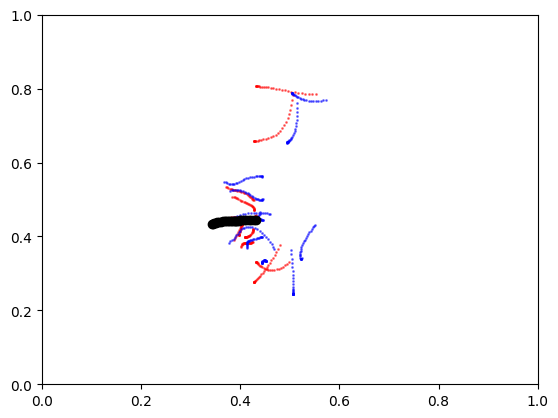

In [16]:
for i in range(1, 23):
    plt.plot(play_data[f'p{i}x'], play_data[f'p{i}y'], '.', color='red' if i <= 11 else 'blue', markersize=2, alpha=0.5)
plt.plot(play_data['ballx'], play_data['bally'], 'o', color='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

## Load Models

In [17]:
model_l1 = MDN(input_dim=len(MODEL_LAYERS['layer_1']['input']), output_dim=len(MODEL_LAYERS['layer_1']['output']), n_gaussians=n_gaussians).to(DEVICE)
model_l1.load_state_dict(torch.load('modeling/models/v0_layer_1.pt'))

model_l2 = MDN(input_dim=len(MODEL_LAYERS['layer_2']['input']), output_dim=len(MODEL_LAYERS['layer_2']['output']), n_gaussians=n_gaussians).to(DEVICE)
model_l2.load_state_dict(torch.load('modeling/models/v0_layer_2.pt'))

model_l3 = MDN(input_dim=len(MODEL_LAYERS['layer_3']['input']), output_dim=len(MODEL_LAYERS['layer_3']['output']), n_gaussians=n_gaussians).to(DEVICE)
model_l3.load_state_dict(torch.load('modeling/models/v0_layer_3.pt'))

C:\Users\tiago\AppData\Local\Temp\ipykernel_23312\2978059573.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_l1.load_state_dict(torch.load('modeling/models/v0_laye

<All keys matched successfully>

In [18]:
import random

100%|██████████| 27/27 [00:00<00:00, 145.03it/s]


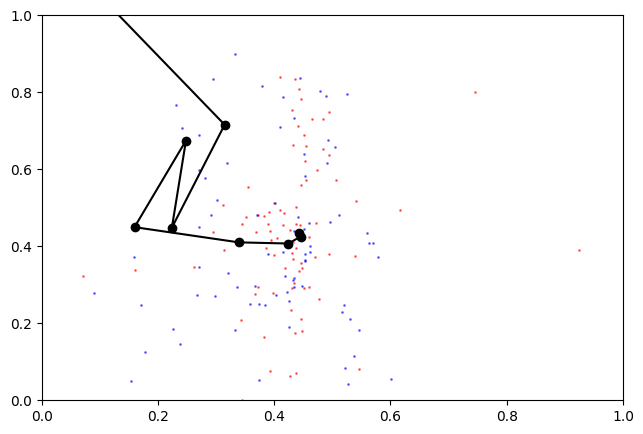

In [19]:
frames = []

current_frame = play_data.iloc[0][MODEL_LAYERS['layer_1']['input']].values.tolist()
for i in tqdm(range(play_data.shape[0])):
    x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
    mu, sigma, pi = model_l1(x)
    l1_samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()

    dx = l1_samples.flatten() - current_frame[bf+2:bf+24]

    x = torch.tensor(np.concatenate([current_frame, dx]), dtype=torch.float32).to(DEVICE).unsqueeze(0)
    mu, sigma, pi = model_l2(x)
    l2_samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()

    dy = l2_samples.flatten() - current_frame[bf+24:bf+46]

    x = torch.tensor(np.concatenate([current_frame, dx, dy]), dtype=torch.float32).to(DEVICE).unsqueeze(0)
    mu, sigma, pi = model_l3(x)
    l3_samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(1).detach().cpu().numpy()

    dball = l3_samples.flatten() - current_frame[bf:bf+2]

    current_frame[bf:bf+2] = l3_samples.flatten()
    current_frame[bf+2:bf+24] = l1_samples.flatten()
    current_frame[bf+24:bf+46] = l2_samples.flatten()
    current_frame[bf+46:bf+48] = dball
    current_frame[bf+48:bf+70] = dx
    current_frame[bf+70:bf+92] = dy

    current_frame[1] += 0.01
    
    frames.append(current_frame[bf:bf+46])

frames = pd.DataFrame(frames, columns=CONTEXT_VARS)

plt.rcParams['figure.figsize'] = [7.5, 5]
for i in range(1, 23):
    plt.plot(frames[f'p{i}x'], frames[f'p{i}y'], '.', color='red' if i <= 11 else 'blue', markersize=2, alpha=0.5)
plt.plot(frames['ballx'], frames['bally'], color='black', marker='o')
plt.xlim(0, 1);
plt.ylim(0, 1);

In [ ]:
ball_positions_in_lookahead = {}
max_lookahead = 40

current_frame = play_data.iloc[0][MODEL_LAYERS['layer_1']['input']].values.tolist()
current_frame = [current_frame for _ in range(100)]
x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE)
for i in tqdm(range(max_lookahead + 1)):
    mu, sigma, pi = model_l1(x)
    l1_samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(1)#.flatten()#.detach().cpu().numpy()

    x = torch.concat([x, l1_samples], axis=1)
    mu, sigma, pi = model_l2(x)
    l2_samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(1)#.squeeze(2).flatten()#.detach().cpu().numpy()

    x = torch.concat([x, l2_samples], axis=1)
    mu, sigma, pi = model_l3(x)
    l3_samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(1)#.squeeze(1).flatten()#.detach().cpu().numpy()

    x[:, bf:bf+2] += l3_samples
    x[:, bf+2:bf+24] += l1_samples
    x[:, bf+24:bf+46] += l2_samples
    x[:, bf+46:bf+48] = l3_samples
    x[:, bf+48:bf+70] = l1_samples
    x[:, bf+70:bf+92] = l2_samples

    x[:, 1] += 0.01

    x = x[:, :bf+92]

    if (i % 10 == 0) and (i != 0):
        ball_positions_in_lookahead[i] = x.detach().cpu().numpy()[:, bf:bf+2]

100%|██████████| 41/41 [00:16<00:00,  2.48it/s]


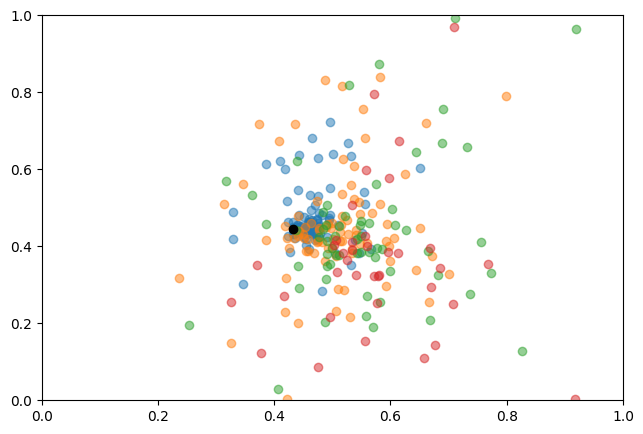

In [ ]:
plt.rcParams['figure.figsize'] = [7.5, 5]
for i, ball_positions in enumerate(ball_positions_in_lookahead.values()):
    lookahead_data = pd.DataFrame(ball_positions, columns=['ballx', 'bally'])
    plt.scatter(lookahead_data['ballx'], lookahead_data['bally'], c=f'C{i}', alpha=0.5)
plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

C:\Users\tiago\AppData\Local\Temp\ipykernel_5132\291512696.py:6: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'], cmap=cmaps[i])
C:\Users\tiago\AppData\Local\Temp\ipykernel_5132\291512696.py:6: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'], cmap=cmaps[i])
C:\Users\tiago\AppData\Local\Temp\ipykernel_5132\291512696.py:6: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'], cmap=cmaps[i])
C:\Users\tiago\AppData\Local\Temp\ipykernel_5132\291512696.py:6: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this 

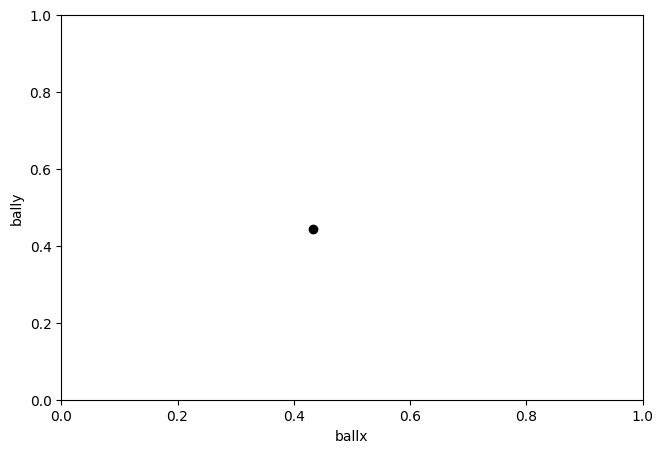

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [7.5, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys']
for i, ball_positions in enumerate(list(ball_positions_in_lookahead.values())[:6]):
    lookahead_data = pd.DataFrame(ball_positions, columns=['ballx', 'bally'])
    sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'], cmap=cmaps[i])
plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

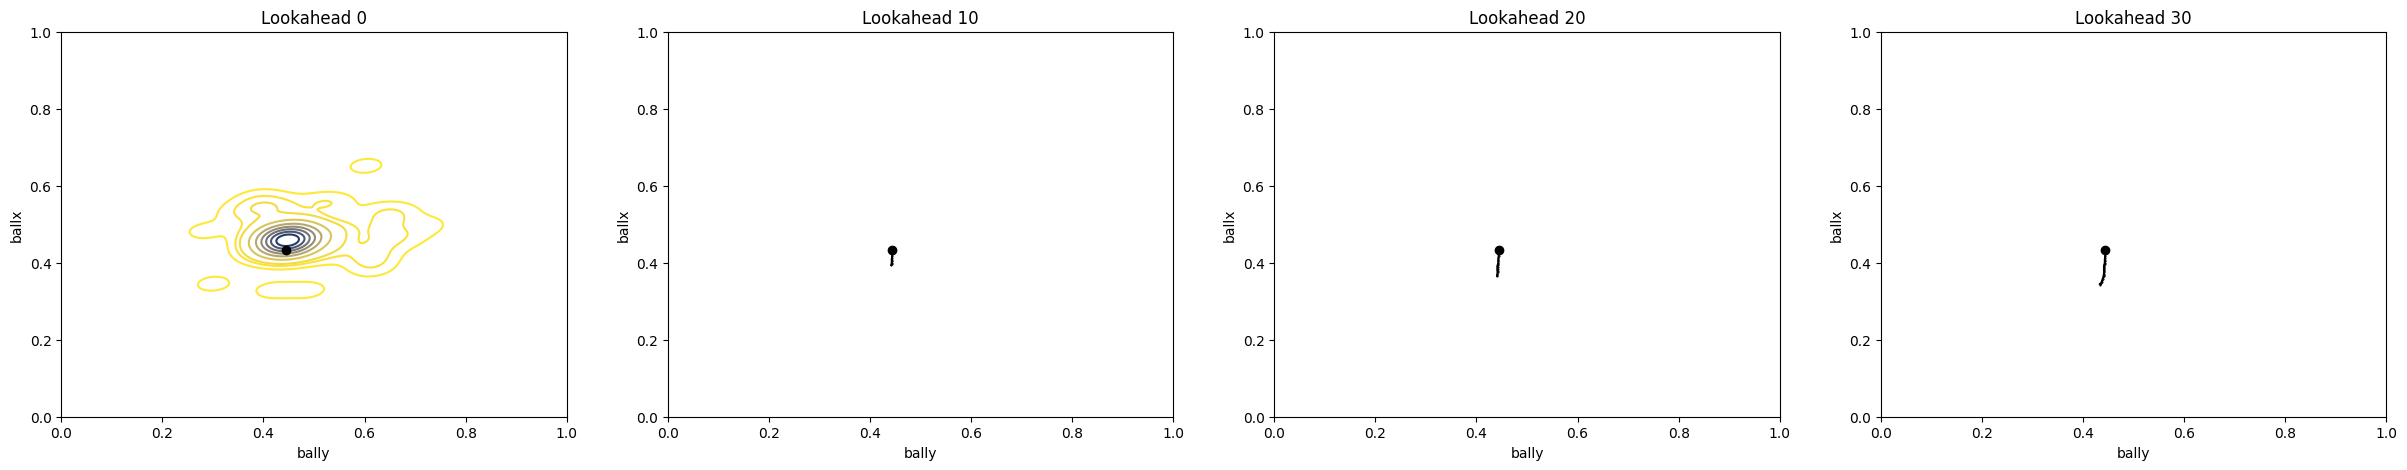

In [ ]:
plt.rcParams['figure.figsize'] = [30, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys', 'pink', 'copper', 'bone', 'hot', 'cool', 'spring', 'summer', 'autumn', 'winter', 'cividis', 'twilight', 'twilight_shifted', 'hsv', 'viridis', 'plasma', 'inferno', 'magma']
n_lookaheads = len(list(ball_positions_in_lookahead.values()))
for i, ball_positions in enumerate(list(ball_positions_in_lookahead.values())):
    plt.subplot(1, n_lookaheads, i+1)
    plt.title(f'Lookahead {i * 10}')
    lookahead_data = pd.DataFrame(ball_positions, columns=['ballx', 'bally'])
    sns.kdeplot(x=lookahead_data['bally'], y=lookahead_data['ballx'], cmap='cividis_r')
    plt.scatter(play_data.iloc[0]['bally'], play_data.iloc[0]['ballx'], c='black', zorder=10)
    plt.plot(play_data.iloc[:10*i]['bally'], play_data.iloc[:10*i]['ballx'], color='black', marker='.', markersize=1)
    plt.xlim(0, 1);
    plt.ylim(0, 1);

In [ ]:
plt.rcParams['figure.figsize'] = [30, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples']
for i, ball_positions_in_lookahead in enumerate([ball_positions_in_lookahead_10, ball_positions_in_lookahead_20, ball_positions_in_lookahead_30, ball_positions_in_lookahead_40]):
    # plt.subplot(1, 4, i+1)
    lookahead_data = pd.DataFrame(ball_positions_in_lookahead, columns=['ballx', 'bally'])
    sns.jointplot(data=lookahead_data, x="ballx", y="bally", kind="kde", cmap=cmaps[i])#hue="species", 
    # sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'])
    plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
    plt.xlim(0, 1);
    plt.ylim(0, 1);

NameError: name 'ball_positions_in_lookahead_10' is not defined

In [ ]:
current_frame = play_data.iloc[0][features].values
x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
mu, sigma, pi = model(x)
mu.flatten()

In [ ]:
current_frame.round(4)

In [ ]:
sigma.flatten()

In [ ]:
mu.flatten().detach().cpu().numpy() - current_frame.round(4)